This notebook shows how to apply PCA and XGB Boosted Forest Classifers to a multiclass classification problem. 
In addition, we compute various performance metrics on the fitted model, applied to both training and testing dataset. 

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
class classifier_statistics:
    
    # cm_{ij}: group i is true label, group j is predicted label (opposite of wiki) 
    
    def __init__(self):
        self.data=[]
    
    def precision(self,cm,method='array'):
        n = len(cm)
        out = np.zeros(n)
        for i in range(n):
            b = np.sum(cm[:,i])
            if(b==0.):
                out[i] = 1.
            else:
                out[i] = cm[i][i]/b

        if(method=='avg'):
            out = np.mean(out)
        return out


    def recall(self,cm,method='array'):
        n = len(cm)
        out = np.zeros(n)
        for i in range(n):
            b = np.sum(cm[i,:])
            if(b==0.):
                out[i] = 1.
            else:
                out[i] = cm[i][i]/b
        if(method=='avg'):
            out = np.mean(out)
        return out

    def accuracy(self,cm):
        n = len(cm)
        num = np.sum([cm[i][i] for i in range(n)])
        denom = np.sum(cm)
        return (num/denom)


    def F1(self,cm):
        prec = self.precision(cm,'avg')
        rec = self.recall(cm,'avg')
        out = 2*prec*rec/(prec+rec)
        return out


def prepare_data(xtrain,xtest,ncomponents):
    mu = np.mean(xtrain,axis=0)
    sigma = np.std(xtrain,axis=0,ddof=0)

    xtrain = (xtrain-mu)/sigma # using biased variance
    xtest = (xtest-mu)/sigma # using biased variance, use train data

    pca = PCA(n_components=ncomponents) # PCA
    xtrain = pca.fit_transform(xtrain)
    xtest = pca.transform(xtest) # train data

    return xtrain,xtest,pca


def visualize(df_pc,names,title_name):
    fig,ax = plt.subplots(1,1)
    for i in range(len(target_names)):
        df = df_pc[df_pc['targets']==i]
        ax.scatter(df['PC1'],df['PC2'],label=target_names[i])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title_name+' set PCA Decomposition Iris Dataset')
    ax.legend()
    return fig,ax

In [16]:
# Load data & PCA
iris = load_iris()

target_names = {}
for i in range(len(iris.target_names)):
    target_names[i] = iris.target_names[i]

x, y = iris.data, iris.target

xtrain_raw, xtest_raw, ytrain, ytest=train_test_split(x, y, test_size=0.3,random_state=5)
xtrain,xtest,pca = prepare_data(xtrain_raw,xtest_raw,2)

df_train = pd.DataFrame(xtrain,columns=['PC1','PC2'])
df_train['targets'] = ytrain
df_test = pd.DataFrame(xtest,columns=['PC1','PC2'])
df_test['targets'] = ytest

print('Explained variance:',round(sum(pca.explained_variance_ratio_),4))

Explained variance: 0.9611


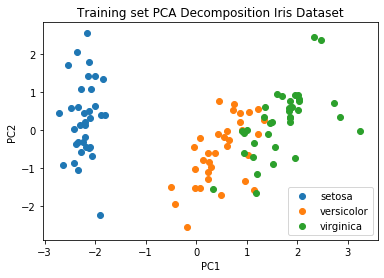

In [5]:
visualize(df_train,target_names,'Training')
None

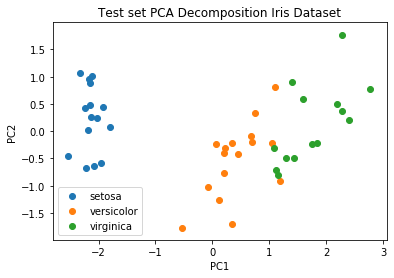

In [6]:
# nothing to see here
visualize(df_test,target_names,'Test')
None

In [13]:
# Fit Model
param = {'max_depth':2,'n_estimators':2,'objective':'multi:softmax','booster':'gbtree','learning_rate':0.1}
xgbc = xgb.XGBClassifier(**param)
xgbc_temp = xgb.XGBClassifier(**param)

xgbc.fit(xtrain, ytrain)

ytrain_pred = xgbc.predict(xtrain)
ytest_pred = xgbc.predict(xtest)
ytest_proba = xgbc.predict_proba(xtest)
cm_train = confusion_matrix(ytrain,ytrain_pred)    
cm_test = confusion_matrix(ytest,ytest_pred)

print(cm_test)
xgbc.feature_importances_

[[15  0  0]
 [ 0 13  3]
 [ 0  0 14]]


array([0.9868976 , 0.01310242], dtype=float32)

In [14]:
# Ascertain quality of model:
# Look at cross-validation metrics on subtrain and subtest(=validation) set
# Look at metrics on full train and test(=holdout) set
nsplits = 10
mc_stats = classifier_statistics()    
kfold = KFold(n_splits=nsplits, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, xtrain, ytrain, cv=kfold)


df_stats = pd.DataFrame([
    ['Avg Precision', mc_stats.precision(cm_train,'avg'),  mc_stats.precision(cm_test,'avg')],
    ['Avg Recall',    mc_stats.recall(cm_train,'avg'),     mc_stats.recall(cm_test,'avg')],
    ['Accuracy',      mc_stats.accuracy(cm_train),         mc_stats.accuracy(cm_test)],
    ['Avg F1',        mc_stats.F1(cm_train),               mc_stats.F1(cm_test)],
    ['KFold Score',   np.nan,                                  np.mean(kf_cv_scores)]],
columns=['Statistic','Train','Test'])
df_stats = df_stats.groupby('Statistic').agg({'Train':'mean','Test':'mean'})


df_kfold_stats = pd.DataFrame(columns=['Statistic','kfold_subtrain','kfold_subtest'])
for train_index, test_index in kfold.split(xtrain):
    X_train, X_test = xtrain[train_index], xtrain[test_index]
    Y_train, Y_test = ytrain[train_index], ytrain[test_index]

    xgbc_temp.fit(X_train, Y_train)
    
    Y_train_pred = xgbc_temp.predict(X_train)
    cm_kfold_train = confusion_matrix(Y_train,Y_train_pred)
        
    Y_test_pred = xgbc_temp.predict(X_test)
    cm_kfold_test = confusion_matrix(Y_test,Y_test_pred)

    df_kfold_stats_helper = pd.DataFrame([
        ['Avg Precision', mc_stats.precision(cm_kfold_train,'avg'),  mc_stats.precision(cm_kfold_test,'avg')],
        ['Avg Recall',    mc_stats.recall(cm_kfold_train,'avg'),     mc_stats.recall(cm_kfold_test,'avg')],
        ['Accuracy',      mc_stats.accuracy(cm_kfold_train),         mc_stats.accuracy(cm_kfold_test)],
        ['Avg F1',        mc_stats.F1(cm_kfold_train),               mc_stats.F1(cm_kfold_test)]],
    columns=['Statistic','kfold_subtrain','kfold_subtest'])

    df_kfold_stats = df_kfold_stats.append(df_kfold_stats_helper)    

df_kfold_stats = df_kfold_stats.groupby('Statistic').agg({'kfold_subtrain':'mean','kfold_subtest':'mean'})
df_stats_final = pd.concat([df_kfold_stats,df_stats],axis=1,sort=False)
round(df_stats_final,2)

# Training and test metrics are comparable, doesn't seem like overfitting

,kfold_subtrain,kfold_subtest,Train,Test
Accuracy,0.92,0.86,0.92,0.93
Avg F1,0.93,0.89,0.93,0.94
Avg Precision,0.93,0.89,0.93,0.94
Avg Recall,0.92,0.88,0.92,0.94
KFold Score,NaN,NaN,NaN,0.86


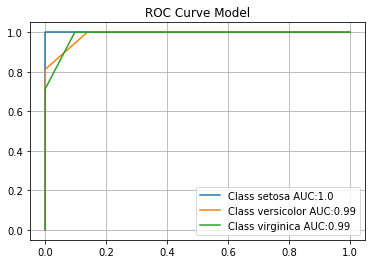

In [15]:
# Plot Multiclass One versus All ROC curve on test set, calculate AUC
tpr = {}
fpr = {} 
thresh = {}
auc = {}
n_class = len(cm_test)

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] =  metrics.roc_curve(ytest, ytest_proba[:,i], pos_label=i)
    auc[i] = round(metrics.auc(fpr[i], tpr[i]),2)


fig,ax = plt.subplots(1,1)
for i in range(n_class):
    ax.plot(fpr[i],tpr[i],label='Class '+str(target_names[i])+' AUC:'+str(auc[i]))
ax.legend()
ax.set_title('ROC Curve Model')
ax.grid()
None